In [17]:
%%capture
!pip install scikit-plot

In [81]:
!pip install keras_utils

In [41]:
import math
import cv2
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Replace the import statement for np_utils
# from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!unzip '/content/drive/MyDrive/Facial Emotion Recognition(FER).zip' -d '/content/drive/MyDrive/Facial Emotion Recognition(FER)_unzip'

Archive:  /content/drive/MyDrive/Facial Emotion Recognition(FER).zip
  inflating: /content/drive/MyDrive/Facial Emotion Recognition(FER)_unzip/fer2013.csv  


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Facial Emotion Recognition(FER)_unzip/fer2013.csv')
print(data.shape)
data.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [6]:
#Text to numerical labeling
emotions_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [7]:
data.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [13]:
#calculate the side length of the images
math.sqrt(len(data.pixels[0].split(' ')))

48.0

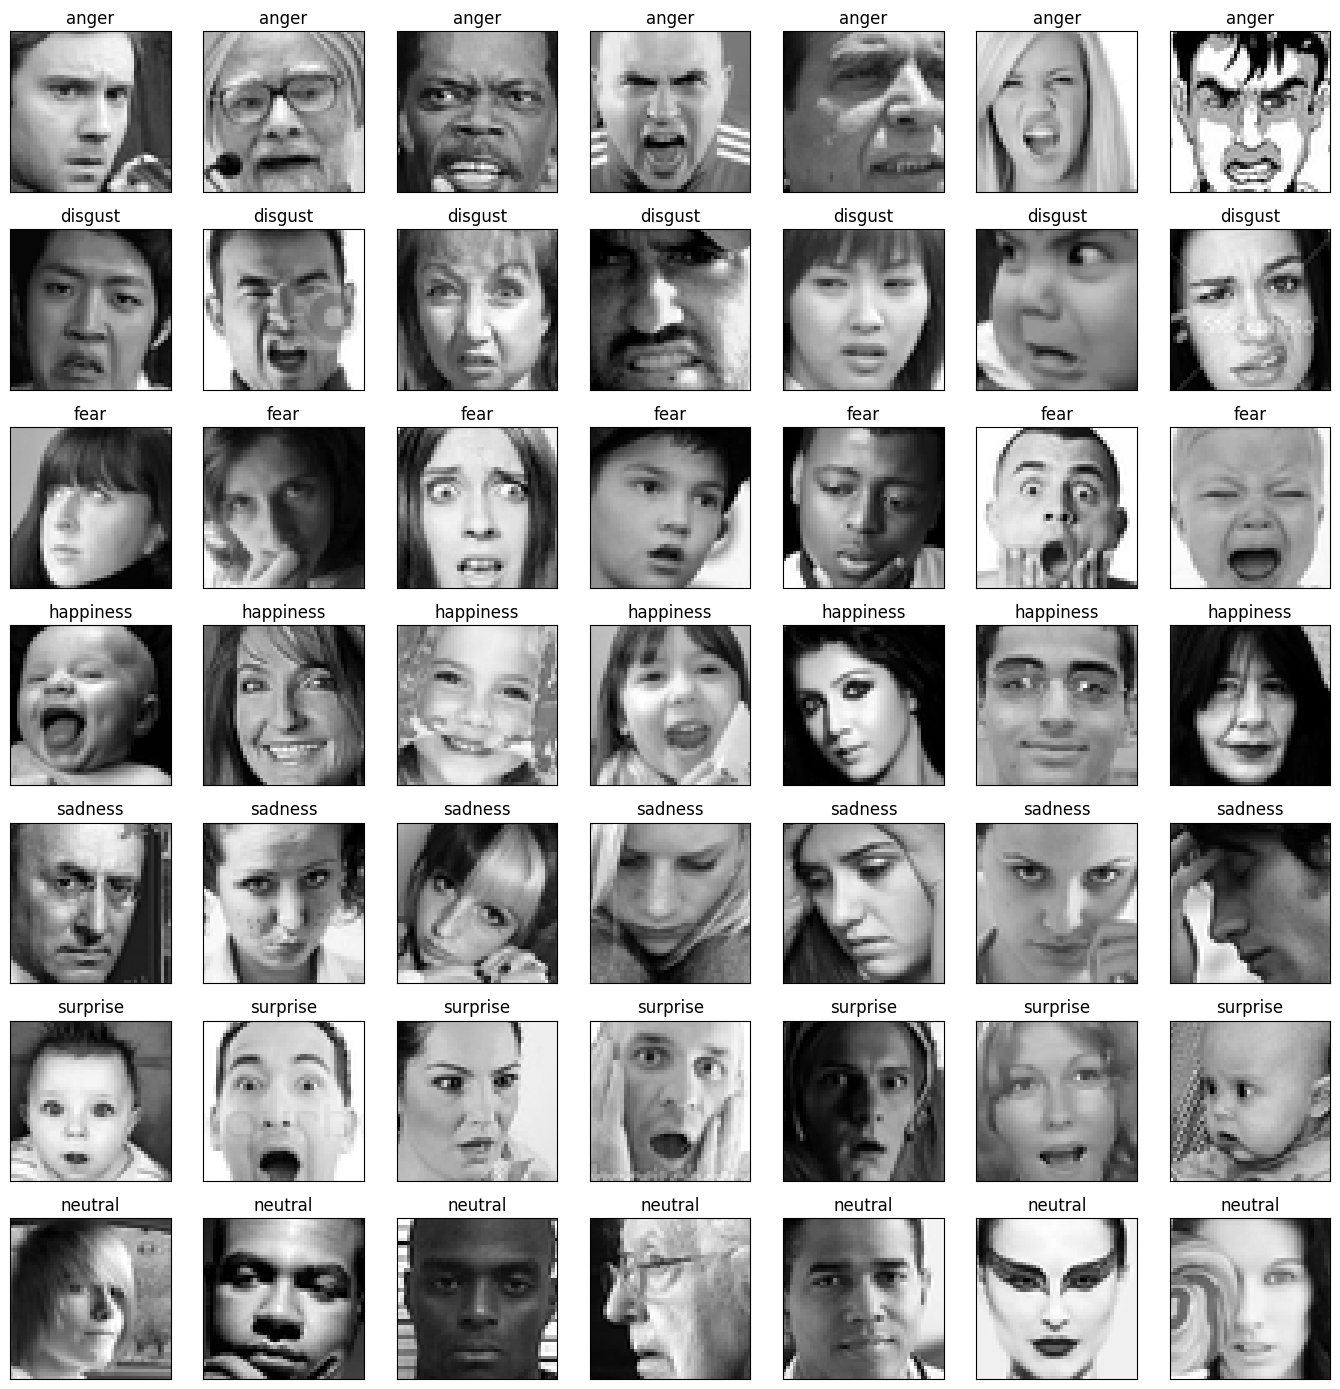

In [14]:
#Viewing the images
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(data.emotion.unique()):
    for j in range(7):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions_labels[label])
        pyplot.tight_layout()


In [15]:
img_array = data.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [16]:
#Viewing the shape of image array created
img_array.shape

(35887, 48, 48)

In [20]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


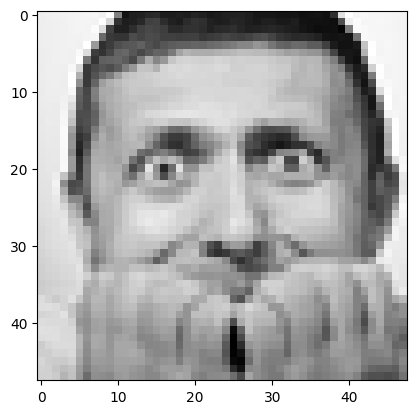

In [21]:
#Showing an image from those
pyplot.imshow(img_features[300].astype(np.uint8));

In [25]:
le = LabelEncoder()
img_labels = le.fit_transform(data.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [26]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [27]:
#Train and Test split of data
face_train, face_valid, y_train, y_valid = train_test_split(img_features, img_labels, shuffle = True, stratify = img_labels, test_size = 0.1, random_state = 42)
face_train.shape, face_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [28]:
img_width = face_train.shape[1]
img_height = face_train.shape[2]
img_depth = face_train.shape[3]
num_classes = y_train.shape[1]

In [29]:
face_train = face_train / 255.
face_valid = face_valid / 255.

In [30]:
# Loading VGG19 convolutional neural network (CNN) from Keras
vgg19 = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False, input_shape = (48, 48, 3))

In [31]:
# Making all layers of VGG19 model non-trainable
for layer in vgg19.layers:
    layer.trainable = False

In [32]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [33]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)

    return model

In [36]:
head = build_model(vgg19, num_classes)
model = Model(inputs = vgg19.input, outputs = head)

In [42]:
#'early stopping' for avoiding overfitting training data and `ReduceLROnPlateau` for learning rate

early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0.00005,
                               patience = 11,
                               verbose = 1,
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 factor = 0.5,
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

In [43]:
#Generating more training data
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(face_train)

batch_size = 32
epochs = 25
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [46]:
history = model.fit(train_datagen.flow(face_train,
                                       y_train,
                                       batch_size = batch_size),
                                       validation_data = (face_valid, y_valid),
                                       steps_per_epoch = len(face_train) / batch_size,
                                       epochs = 5,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/5
1009/1009 [==============================] - 1143s 1s/step - loss: 1.7365 - accuracy: 0.2941 - val_loss: 1.7077 - val_accuracy: 0.3210 - lr: 1.0000e-04
Epoch 2/5
1009/1009 [==============================] - 1174s 1s/step - loss: 1.7165 - accuracy: 0.3063 - val_loss: 1.6872 - val_accuracy: 0.3296 - lr: 1.0000e-04
Epoch 3/5
1009/1009 [==============================] - 1169s 1s/step - loss: 1.7025 - accuracy: 0.3120 - val_loss: 1.6749 - val_accuracy: 0.3335 - lr: 1.0000e-04
Epoch 4/5
1009/1009 [==============================] - 1171s 1s/step - loss: 1.6941 - accuracy: 0.3204 - val_loss: 1.6664 - val_accuracy: 0.3349 - lr: 1.0000e-04
Epoch 5/5
1009/1009 [==============================] - 1136s 1s/step - loss: 1.6896 - accuracy: 0.3193 - val_loss: 1.6638 - val_accuracy: 0.3363 - lr: 1.0000e-04


In [47]:
model_yaml = model.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

model.save("model.h5")

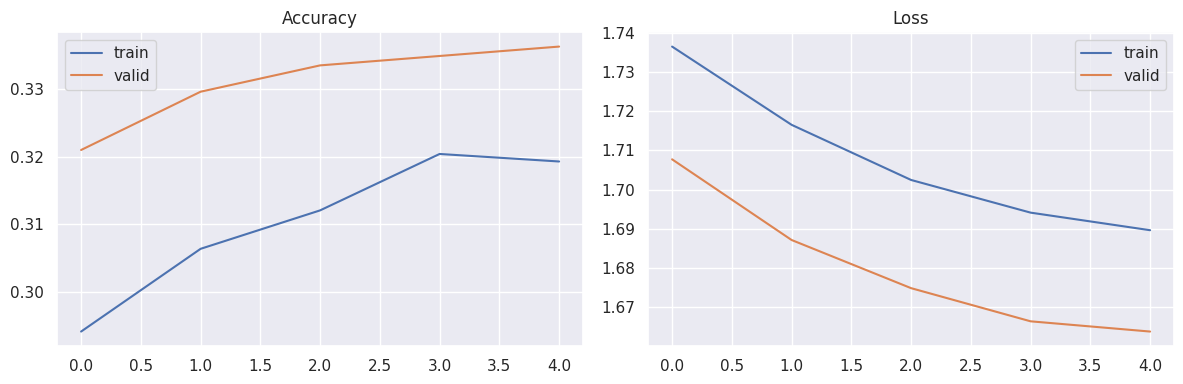

In [48]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

In [51]:
print(data_accu.head())
print(data_loss.head())

      train     valid
0  0.294074  0.320981
1  0.306335  0.329618
2  0.312032  0.333519
3  0.320391  0.334912
4  0.319277  0.336305
      train     valid
0  1.736501  1.707736
1  1.716540  1.687154
2  1.702470  1.674867
3  1.694134  1.666406
4  1.689649  1.663793


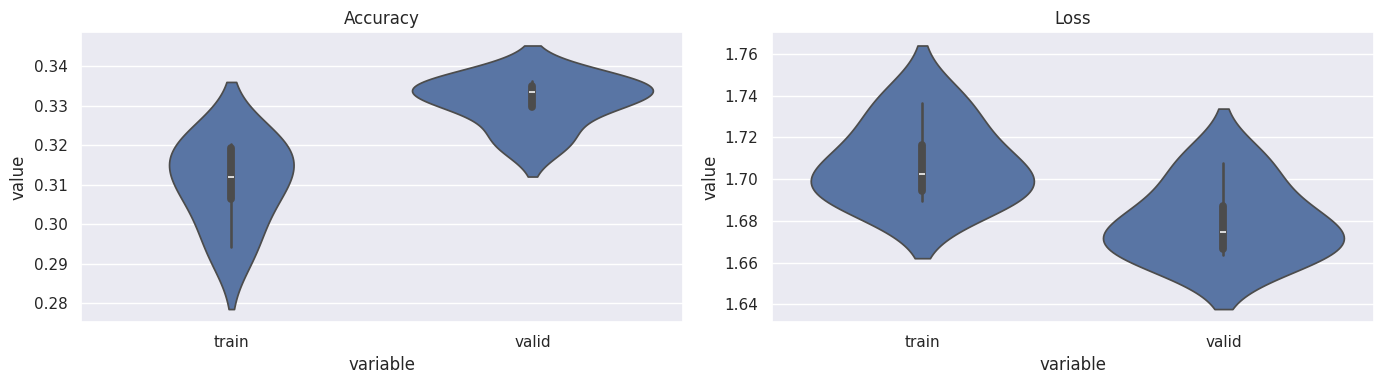

In [52]:
data_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
data_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(data_accu))
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(data_loss))
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

113/113 [==============================] - 114s 1s/step
total wrong validation predictions: 2382


              precision    recall  f1-score   support

           0       0.34      0.04      0.08       495
           1       0.00      0.00      0.00        55
           2       0.41      0.05      0.09       512
           3       0.31      0.90      0.47       899
           4       0.34      0.11      0.16       608
           5       0.44      0.52      0.48       400
           6       0.35      0.13      0.18       620

    accuracy                           0.34      3589
   macro avg       0.31      0.25      0.21      3589
weighted avg       0.35      0.34      0.25      3589



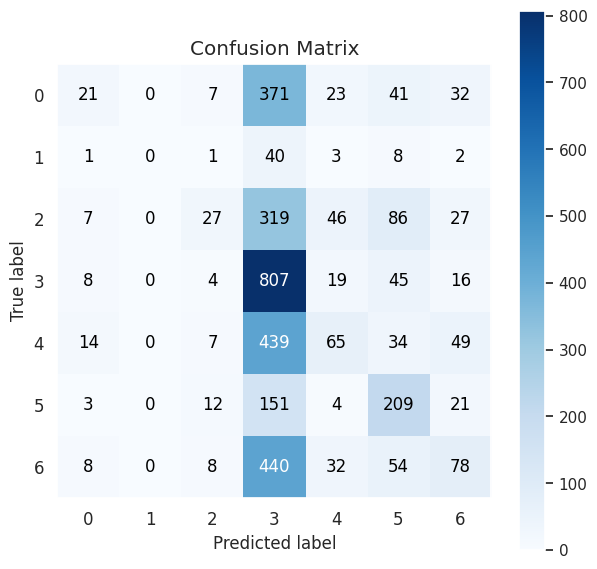

In [53]:
yhat_valid = np.argmax(model.predict(face_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [54]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

1/1 [==============================] - 0s 69ms/step


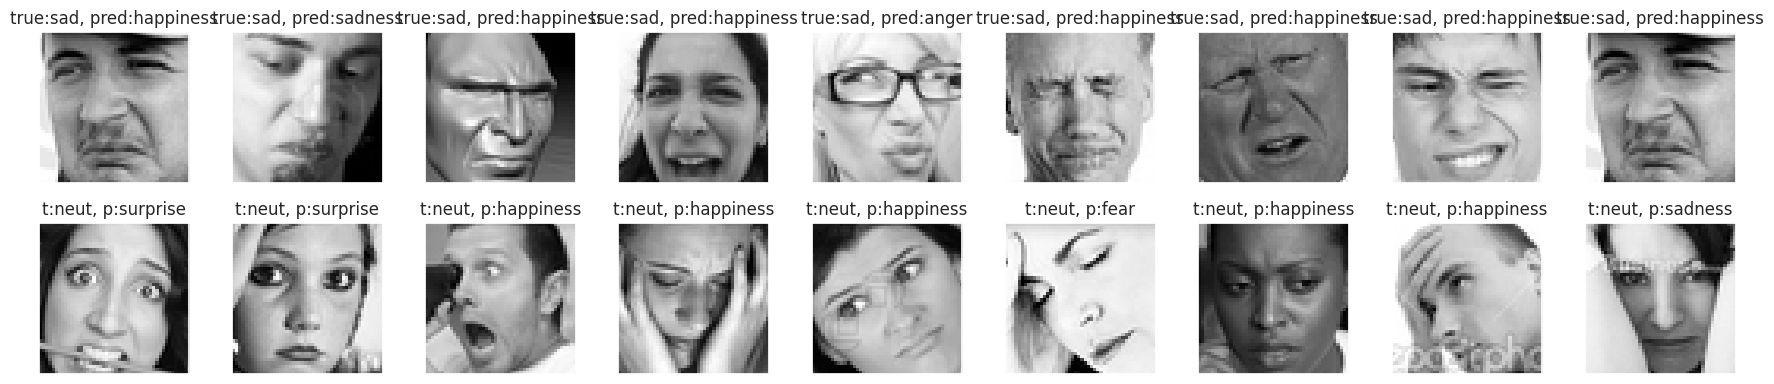

In [55]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = face_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = face_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

        ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        pyplot.tight_layout()

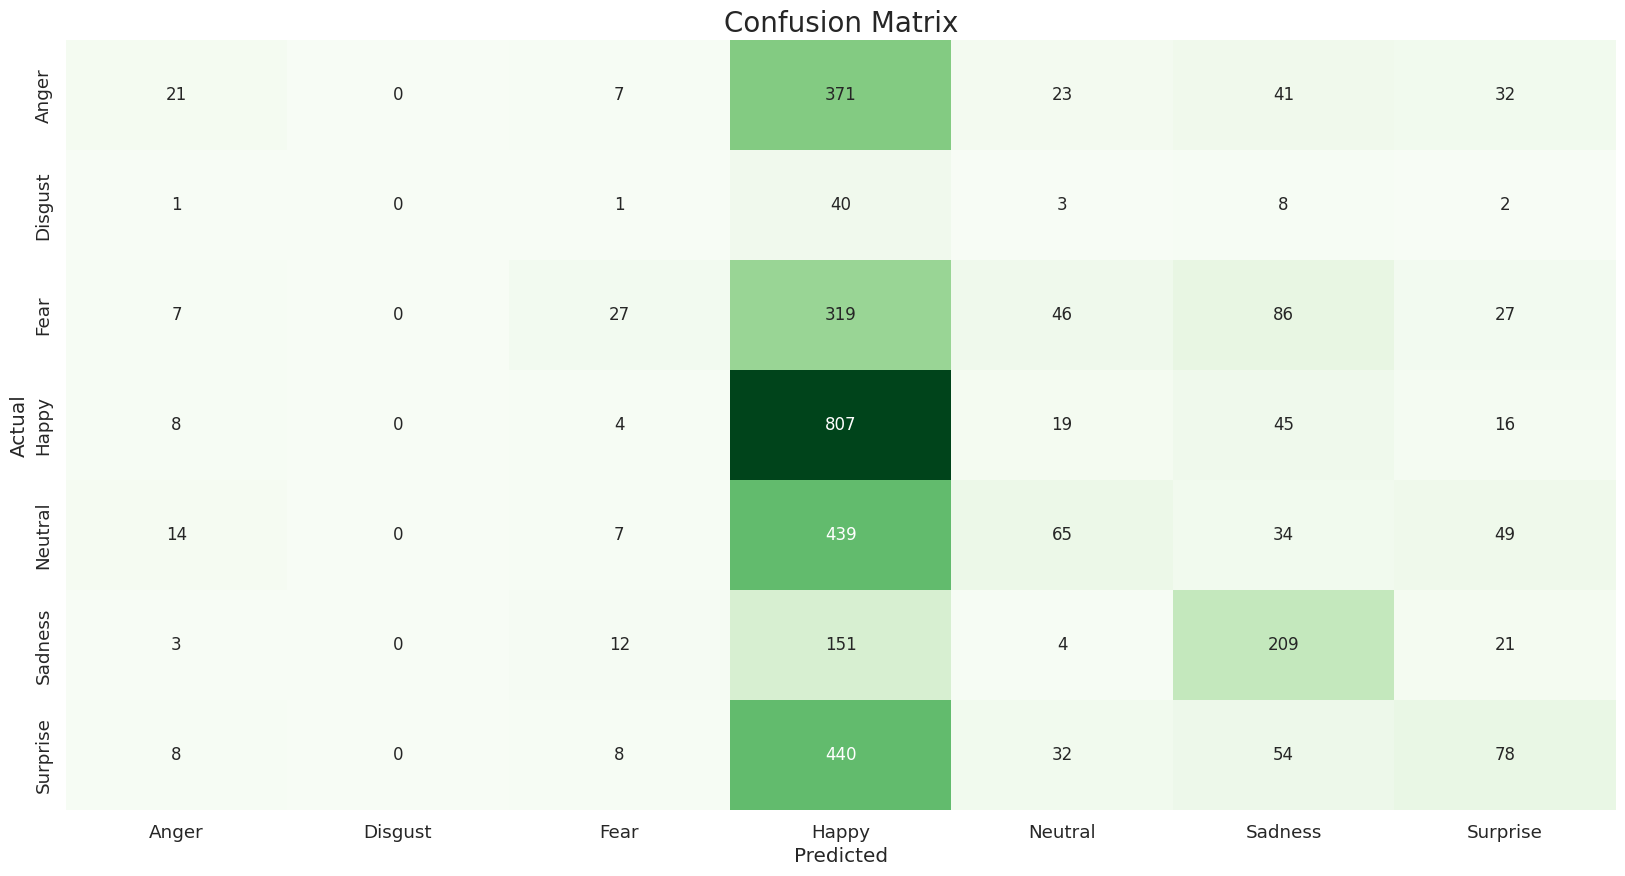

In [61]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_valid, axis = 1 ), yhat_valid)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Greens", annot=True, annot_kws={"size": 12}, fmt='g')

In [62]:
print(classification_report(np.argmax(y_valid, axis = 1 ),yhat_valid,digits=3))

              precision    recall  f1-score   support

           0      0.339     0.042     0.075       495
           1      0.000     0.000     0.000        55
           2      0.409     0.053     0.093       512
           3      0.314     0.898     0.466       899
           4      0.339     0.107     0.163       608
           5      0.438     0.522     0.477       400
           6      0.347     0.126     0.185       620

    accuracy                          0.336      3589
   macro avg      0.312     0.250     0.208      3589
weighted avg      0.350     0.336     0.253      3589

